# A MadMiner Example Analysis -  Analyzing dim6 operators in $W\gamma$ 

## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

### 5. Calculate Fisher Information at Truth Level

### 5a) Initialize the Fisherinformation module 

Here we calculate the Parton Level Fisher Information, using the data extracted from the LHE file. This is done by the MadFisher package. To initialize it, we load the data from an HDF5 file.

In [2]:
mf = FisherInformation('data/madminer_lhedata.h5')

No handlers could be found for logger "madminer.fisherinformation"


### 5b) Calculate Fisher Info

We can now calculate the Fisher Information for a given benchmark and a given luminosity (in units of pb$^{-1}$) after considering a set of cuts and efficiencies. Note that `cuts` and `observable` can be any function of observables defined when initializing the LHEProcessor, including `sin`, `cos`, `tan`, `asin`, `acos`, `atan` and `exp`.

In [3]:
# Define Benchmark
thistheta=np.array([0,0])

#Define luminosity in inverse pb
thislumi=100*1000;

#Define Cuts
thiscuts = []

We can now calculate different the Fisher Information (and its covariance)

- `calculate_fisher_information_full_truth(theta,luminosity)`, which calculates the full Fisher Info, by summing over the Fisher Infos for each event passing the cuts: $I_{ij}^{full} = \sum_{events} I_{ij}(w_i)$

- `calculate_fisher_information_rate(theta,luminosity)`, which calculates the Fisher Info corresponding to only the rate, by evaluating the Fisher Info of the sum the weights of all events passing the cuts: $I_{ij}^{rate} =  I_{ij}(\sum_{events} w_i)$ 

Additional options include for example `cuts` or `efficiency_functions`. 

In [4]:
fi_full, fi_full_cov = mf.calculate_fisher_information_full_truth(
    theta=thistheta,
    luminosity=thislumi,
    cuts=thiscuts
)
fi_rate, fi_rate_cov = mf.calculate_fisher_information_rate(
    theta=thistheta,
    luminosity=thislumi,
    cuts=thiscuts
)

Additionally, we can also calculate the Fihser Information stored in histograms (Note that we take into account underflow/overflow bins)

- `calculate_fisher_information_hist1d(theta,luminosity,cuts,observable,nbins,histrange)`, which calculates the Fisher Info in a 1D histogram, by summing over the Rate Fisher Infos for each bin in the 1D Histogram: $I_{ij}^{hist} =  \sum_{bins} I_{ij}(w_i)$

- `calculate_fisher_information_hist2d(theta,luminosity,cuts,observable1,nbins1,histrange1,observable2,nbins2,histrange2)`, which calculates the Fisher Info in a 2D histogram, by summing over the Rate Fisher Infos for each bin in the 2D Histogram: $I_{ij}^{hist} =  \sum_{bins} I_{ij}(w_i)$

In [5]:
fi_dphi, fi_dphi_cov = mf.calculate_fisher_information_hist1d(
    theta=thistheta,
    luminosity=thislumi,
    observable='dphi_lv',
    nbins=20,
    histrange=(-1,1)
)
fi_pta, fi_pta_cov = mf.calculate_fisher_information_hist1d(
    theta=thistheta,
    luminosity=thislumi,
    observable='pt_a',
    nbins=20,
    histrange=(0,1000)
)
fi_2d, fi_2d_cov = mf.calculate_fisher_information_hist2d(
    theta=thistheta,
    luminosity=thislumi,
    observable1='dphi_lv',
    nbins1=20,
    histrange1=(-1,1),
    observable2='pt_a',
    nbins2=20,
    histrange2=(0,1000)
)

/Users/felixkling/Documents/GitHub/madminer/madminer/fisherinformation.py:1184: RuntimeWarning: divide by zero encountered in true_divide
  inv_sigma = sanitize_array(1.0 / sigma)  # Shape (n_events,)


Let us now look at the different Fisher Information matrices

In [6]:
print ('Full Fisher Info: \n' , fi_full , "\n Determinant: ", np.linalg.det(fi_full) )  
print ('Rate Fisher Info: \n' , fi_rate , "\n Determinant: ", np.linalg.det(fi_rate) )
print ('pt_a Fisher Info: \n' , fi_pta  , "\n Determinant: ", np.linalg.det(fi_pta)  ) 
print ('dphi Fisher Info: \n' , fi_dphi , "\n Determinant: ", np.linalg.det(fi_dphi) ) 
print ('2D   Fisher Info: \n' , fi_2d   , "\n Determinant: ", np.linalg.det(fi_2d)   ) 

Full Fisher Info: 
 [[0.01784445 0.00038136]
 [0.00038136 0.07108635]] 
 Determinant:  0.001268351075524971
Rate Fisher Info: 
 [[2.16645085e-04 3.22508717e-05]
 [3.22508717e-05 4.80102620e-06]] 
 Determinant:  8.347259023907472e-26
pt_a Fisher Info: 
 [[2.26067036e-04 3.21358038e-05]
 [3.21358038e-05 2.66351143e-05]] 
 Determinant:  4.98861146797947e-09
dphi Fisher Info: 
 [[2.97376623e-04 2.06905514e-05]
 [2.06905514e-05 3.61453141e-02]] 
 Determinant:  1.0748343375195398e-05
2D   Fisher Info: 
 [[3.70493441e-04 5.60040448e-05]
 [5.60040448e-05 4.03026487e-02]] 
 Determinant:  1.4928730551291165e-05


### 5c) Project and Profile 

In many cases, we will calculate large $n \times n$ Fisher Info matrices. The dimensionality of the Fisher Information tensor can be reduced by either ignoring components (setting them to zero) or by profiling over components. This is done by the following two functions:
- `project_information(fisher_info, remaining_components)`
- `profile_information(fisher_info, remaining_components)`
where `fisher_info` is the original Fisher Information tensor and `remaining_components` is a list of indices of which rows / columns to keep. Note that both functions can also project/profile the covariance of the Fisher Information.

In [7]:
fi_full_proj, fi_full_cov_proj = project_information(
    fisher_information=fi_full,
    covariance=fi_full_cov,
    remaining_components=[0] 
)

fi_full_prof, fi_full_cov_prof = profile_information(
    fisher_information=fi_full,
    covariance=fi_full_cov,
    remaining_components=[0] 
)

print ('Projected out O_W: ', fi_full_proj )
print ('Profiled over O_W: ', fi_full_prof )

Projected out O_W:  [[0.01784445]]
Profiled over O_W:  [[0.0178424]]


### 5d) The Bar Plot

Now it's time to do some physics: Let's compare the Fisher Information tensors for different analysis strategies. This can simply be done using the plotting function `plot_fisherinfo_barplot()`. Its inputs are

- `matrices` list of Fisher Information tensors for upper panel
- `matrices_for_determinants` llist of Fisher Information tensors for lower panel
- `labels` list of names for analysis strategy
- `categories` assignment of category for each label - there will be extra space between categories
- `operatorlabels` list of operator names 
- `filename` save files under filename (starting from current working directory)
- `additional_label` label in lower panel
- `top_label` label above top panel
- `normalise_determinants` are determinants normalized to unity ?
- `use_bar_colors` are bars in lower panel colored or gray ? 
- `eigenvalue_operator_legend` plot legend for operators ?

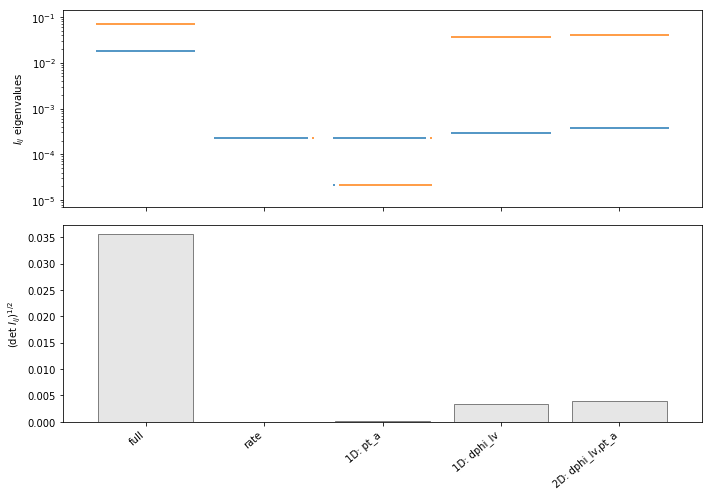

In [8]:
from madminer.plotting import plot_fisherinfo_barplot

list_of_fi=[fi_full,fi_rate,fi_pta,fi_dphi,fi_2d]
list_of_cov=[fi_full_cov,fi_rate_cov,fi_pta_cov,fi_dphi_cov,fi_2d_cov]
list_of_labels=["full","rate","1D: pt_a","1D: dphi_lv","2D: dphi_lv,pt_a"] 
list_of_operators=[r'$\mathcal{O}_{W}$',r'$\mathcal{O}_{\widetilde{W}}$']
list_of_projected_fi=[ project_information(list_of_fi[i],[0]) for i in range(0,len(list_of_fi))] 

barplot = plot_fisherinfo_barplot(
    fisher_information_matrices=list_of_fi,
    labels=list_of_labels
)

### 5e) The Contour Plot

Using the Fisher Information, we can calculate the sensitivity for the coupling measurement. A particularly easy way is the *linearized distance* which is defined as $d(\theta_1, \theta_2) = I_{i,j} (\theta_1 - \theta_2)^i (\theta_1 - \theta_2)^j$.  

The funtion `plot_linearized_contours_2d()` visualize the sensitivity to two operators in a contour plot: it shows the $d(\theta,0)$ contours around the SM-value. Its inputs are

- `fisher_information_matrices` list of 2-dimensional Fisher Information matrices
- `contour_distance` distances contour drawn $d(\theta,0)$ 
- `xlabel` label of x-axis 
- `ylabel` label of y-axis 
- `xrange` range of x-axis
- `yrange` range of y-axis
- `matrix_labels` list of labels corresponding to the Fisher Information matrices 
- `resolution` number of grid points for evaluation of figure, 100 seems reasonable

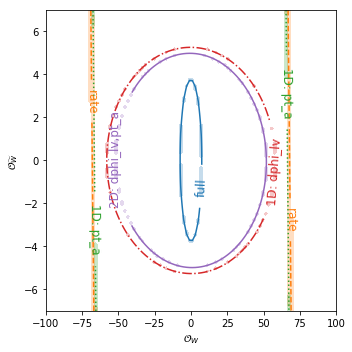

In [9]:
from madminer.plotting import plot_fisher_information_contours_2d

contourplot = plot_fisher_information_contours_2d(
    fisher_information_matrices=list_of_fi, 
    fisher_information_covariances=list_of_cov,
    contour_distance=1,
    xlabel=r'$\mathcal{O}_{W}$',
    ylabel=r'$\mathcal{O}_{\widetilde{W}}$',
    xrange=(-100.,100.),
    yrange=(-7.,7.),
    inline_labels=list_of_labels,
    resolution=100
)

### 5f) The Fisher Information Histogram

We can also look at the kinematic distribution of information. To do so, we first use the function `histogram_of_fisher_information()` to get a histogram of the weight for a given theta (`w_in_histo`), the rate-only fisher information in each bin (`fi_histo_rate`) and total fisher information in each bin (`fi_histo_full`). Here we again can include cuts and efficiencies. 

In the next step we can plot the histogram using the plotting fuction `kinematic_distribution_of_information`. The black line corresponds to the cross section, the red-shaded area to the determinant of the full fisher information distribution and the red dashed line to the determinant of the rate-only fisher information distribution. 

In the example below we only show the Fisher Information on $\mathcal{O}_{\widetilde{W}}$. Once considering higher dimensional Fisher Informations, the rate determinant of the rate-only fisher information will naturally vanish. 

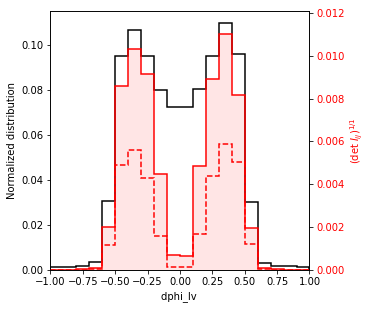

In [10]:
from madminer.plotting import plot_distribution_of_information

bins_histo, w_in_histo, fi_histo_rate, fi_histo_full = mf.histogram_of_fisher_information(
    theta=thistheta,
    luminosity=thislumi,
    observable="dphi_lv",
    nbins=20,
    histrange=(-1,1)
)

proj_fi_histo_rate=[ project_information(fi_histo_rate[i],[1]) for i in range(0,len(fi_histo_rate))] 
proj_fi_histo_full=[ project_information(fi_histo_full[i],[1]) for i in range(0,len(fi_histo_full))] 

histoplot = plot_distribution_of_information(
    xbins=bins_histo, 
    xsecs=w_in_histo,
    fisher_information_matrices=proj_fi_histo_full, 
    fisher_information_matrices_aux=proj_fi_histo_rate,
    xlabel="dphi_lv ",
    xmin=-1,
    xmax=1,
    log_xsec=False,
    norm_xsec=True
)

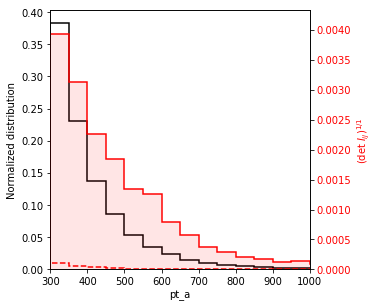

In [11]:
from madminer.plotting import plot_distribution_of_information

bins_histo, w_in_histo, fi_histo_rate, fi_histo_full = mf.histogram_of_fisher_information(
    theta=thistheta,
    luminosity=thislumi,
    observable="pt_a",
    nbins=20,
    histrange=(300,1300)
)

proj_fi_histo_rate=[ project_information(fi_histo_rate[i],[0]) for i in range(0,len(fi_histo_rate))] 
proj_fi_histo_full=[ project_information(fi_histo_full[i],[0]) for i in range(0,len(fi_histo_full))] 

histoplot = plot_distribution_of_information(
    xbins=bins_histo, 
    xsecs=w_in_histo,
    fisher_information_matrices=proj_fi_histo_full, 
    fisher_information_matrices_aux=proj_fi_histo_rate,
    xlabel="pt_a",
    xmin=300,
    xmax=1000,
    log_xsec=False,
    norm_xsec=True
)